In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import vectorbt as vbt

from dffc.holt_winters._holt_winters import HW, HWDP

d:\anaconda3\envs\quant\Lib\site-packages\telegram\utils\request.py:54: UserWarning:

python-telegram-bot wasn't properly installed. Please refer to README.rst on how to properly install.



In [4]:
import numpy as np
import pandas as pd
import vectorbt as vbt
import matplotlib.pyplot as plt
from dffc.holt_winters._holt_winters import HWDP
from dffc.holt_winters._optimization import process_hw_opt
from dffc.fund_data import register_fund_data
from wxy_backtest.hw_dual_reallocation.strategy import DualReallocationStrategy
from abc import ABC, abstractmethod

# 设置vectorbt配置
vbt.settings.array_wrapper['freq'] = 'days'
vbt.settings.returns['year_freq'] = '252 days'
vbt.settings.portfolio['seed'] = 42
vbt.settings.portfolio.stats['incl_unrealized'] = True

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False



register_fund_data()

print("下载数据...")
fund_data = vbt.FundData.download(
    ['007467', '004253'],
    names=['HL', 'GD'],
    start='2022-09-01',
    end='2024-09-01'
)
prices = fund_data.get('cumulative_value').dropna()

# 创建改进的策略
strategy = DualReallocationStrategy(
    prices=prices,
    default_weights=[0.5, 0.5],
    up_weights=[0.2, 0.8],
    down_weights=[0.8, 0.2],
    threshold=1.2,
    adjust_factor=0.2,
    rebalance_freq='D',  # 月度再平衡
    optimization=True
)

# 运行回测
portfolio, rebalance_mask, actual_weights = strategy.run_backtest(initial_cash=100000)

# 分析结果
stats = strategy.analyze_results(portfolio)


FundData already exists in vectorbt namespace
下载数据...
优化Holt-Winters参数...
开始处理 2 个基金...
处理基金 1/2: 007467


Optimizing seasons: 100%|██████████| 18/18 [00:06<00:00,  3.00it/s]


  基金 007467 处理完成！参数: Alpha=0.099267, Beta=0.006841, Gamma=0.144841, Season=7
处理基金 2/2: 004253


Optimizing seasons: 100%|██████████| 18/18 [00:06<00:00,  2.99it/s]


  基金 004253 处理完成！参数: Alpha=0.113196, Beta=0.000000, Gamma=0.316949, Season=19

批量处理完成!
成功处理: 2 个基金
处理失败: 0 个基金
汇总结果保存在: .\processing_summary.csv
生成目标权重序列...
准备回测数据...
总再平衡次数: 230
运行vectorbt回测...

=== 再平衡策略表现分析 ===
总收益率(%): 35.07
夏普比率: 1.80
最大回撤(%): -6.32

详细统计:
Start                           2022-09-01 00:00:00+08:00
End                             2024-08-30 00:00:00+08:00
Period                                  488 days 00:00:00
Start Value                                      100000.0
End Value                                    135067.85396
Total Return [%]                                35.067854
Benchmark Return [%]                            30.518722
Max Gross Exposure [%]                              100.0
Total Fees Paid                               1984.791343
Max Drawdown [%]                                 6.322901
Max Drawdown Duration                    74 days 00:00:00
Total Trades                                          231
Total Closed Trades                       

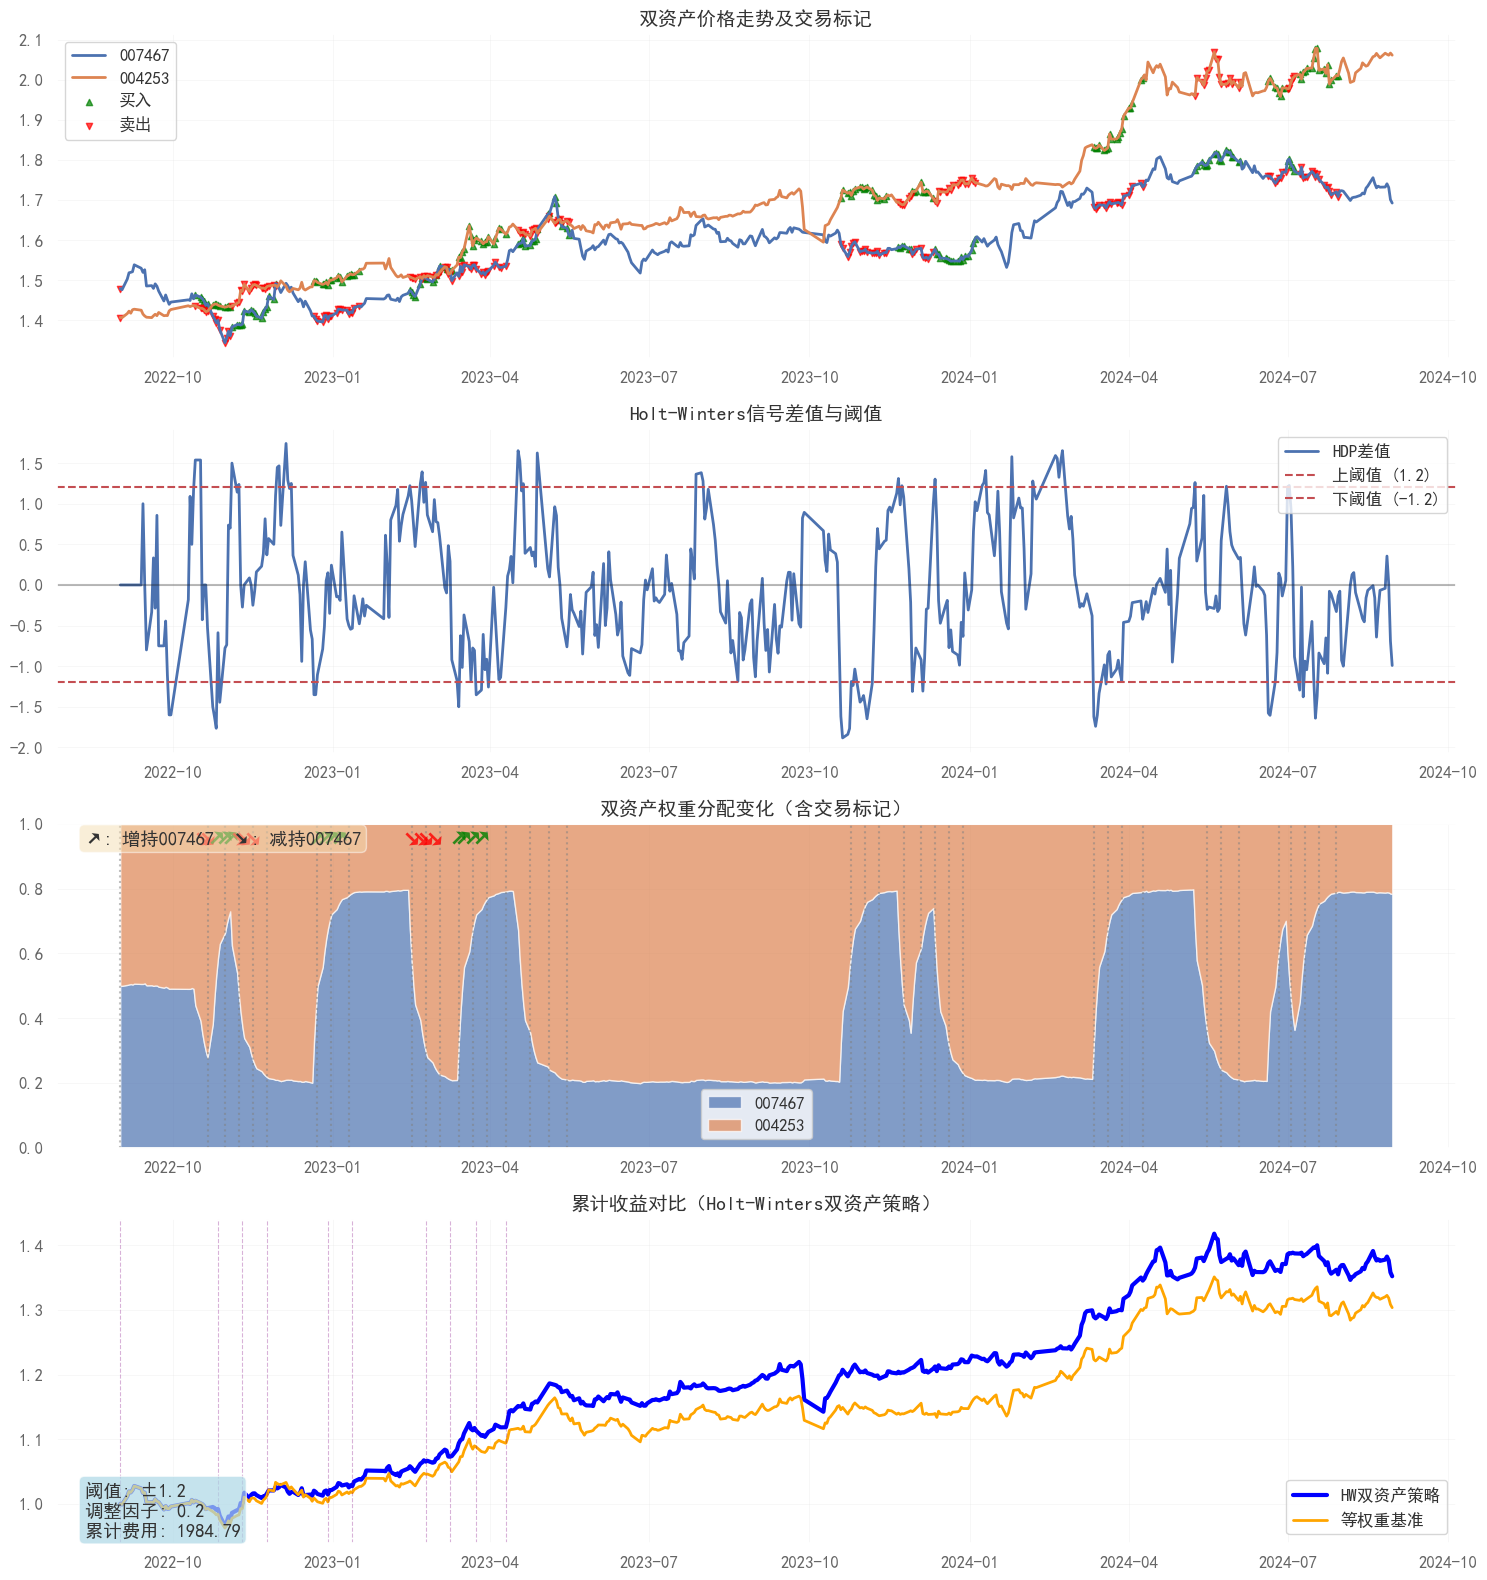


=== 双资产HW策略统计 ===
阈值设置: ±1.2
权重配置: 默认[0.5 0.5], 上升[0.2 0.8], 下降[0.8 0.2]
HW优化: 是
信号分布: 上升37天 (7.6%), 下降36天 (7.4%), 中性415天 (85.0%)
再平衡次数: 230
平均再平衡间隔: 2.1 天


In [5]:
# 绘制结果
strategy.plot_results(portfolio, rebalance_mask)

In [ ]:
num_tests = 1
_prices = strategy.prices.vbt.tile(num_tests) # , keys=pd.Index(np.arange(num_tests), name='symbol_group'))

# 创建再平衡时间表
rb_mask = strategy._create_rebalance_schedule()

# 应用渐进调整
actual_weights, actual_rebalances = strategy._apply_gradual_adjustment(rb_mask)

# 创建订单矩阵
orders = np.full_like(_prices, np.nan)

# 在再平衡日期设置实际权重
for i, should_rebalance in enumerate(actual_rebalances):
    if should_rebalance:
        orders[i, :] = actual_weights.iloc[i].values

orders = pd.DataFrame(orders, index=_prices.index, columns=_prices.columns)

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import vectorbt as vbt

np.random.seed(42)
price = pd.DataFrame({
    'a': np.random.uniform(1, 2, size=100),
    'b': np.random.uniform(1, 2, size=100)
}, index=[datetime(2020, 1, 1) + timedelta(days=i) for i in range(100)])
size = pd.DataFrame({
    'a': np.random.uniform(-1, 1, size=100),
    'b': np.random.uniform(-1, 1, size=100),
}, index=[datetime(2020, 1, 1) + timedelta(days=i) for i in range(100)])
pf = vbt.Portfolio.from_orders(price, size, fees=0.01, freq='d')
orders = pf.orders

In [ ]:
orders.side.to_pd()

In [15]:
portfolio.orders.records

,id,col,idx,size,price,fees,side
0,0,0,0,33808.91,1.4789,49.999997,0
1,1,1,0,35475.68,1.4066,49.900091,0
2,2,0,21,3482.91,1.4509,5.053354,1
3,3,1,21,3511.78,1.4361,5.043267,0
4,4,0,22,3316.46,1.4493,4.806545,1
...,...,...,...,...,...,...,...
557,557,1,667,76.04,2.7823,0.211566,0
558,558,0,668,232.59,1.9140,0.445177,1
559,559,1,668,159.96,2.7774,0.444273,0
560,560,1,729,7013.82,2.8236,19.804222,1


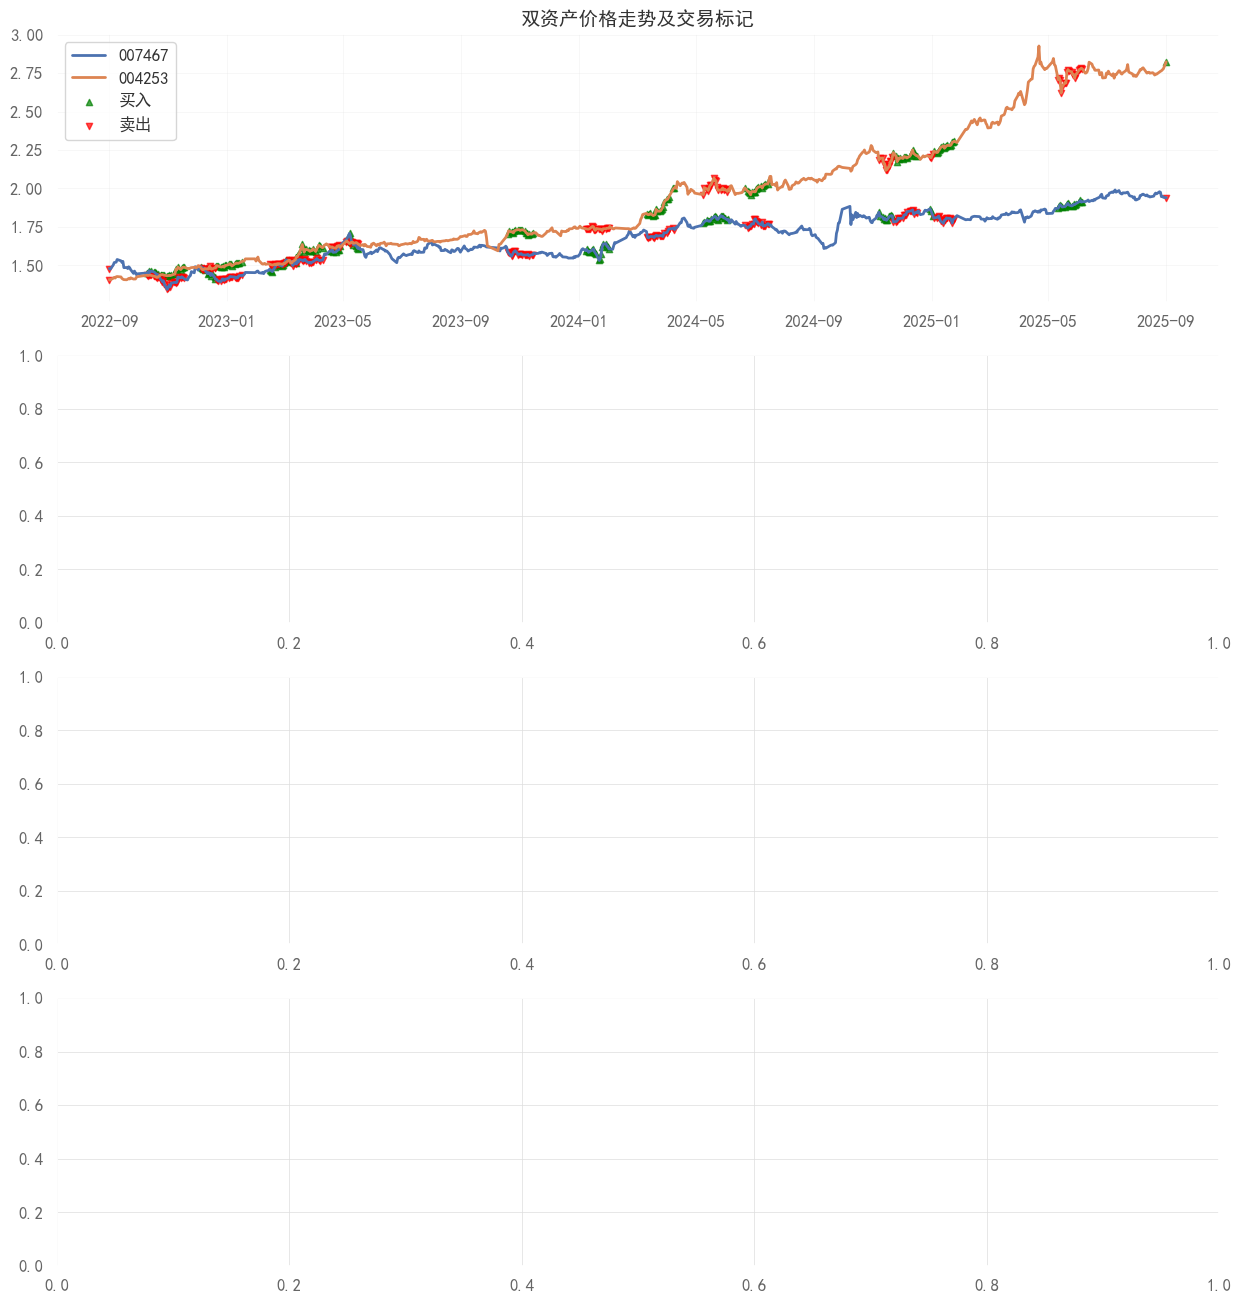

In [31]:
# 获取交易信息
orders = portfolio.orders.records
fig, axes = plt.subplots(4, 1, figsize=(15, 16))

# 1. 价格走势 + 交易标记
axes[0].plot(strategy.prices.index, strategy.prices.iloc[:, 0], 
                label=strategy.prices.columns[0], linewidth=2)
axes[0].plot(strategy.prices.index, strategy.prices.iloc[:, 1], 
                label=strategy.prices.columns[1], linewidth=2)

# 添加买入/卖出标记
if hasattr(orders, 'side'):
    buy_orders = orders.side == 1
    sell_orders = orders.side == 0
    
    buy_times = orders.idx[buy_orders] if buy_orders.any() else []
    sell_times = orders.idx[sell_orders] if sell_orders.any() else []

    axes[0].scatter(strategy.prices.index[buy_times], orders.price[buy_orders], 
                    marker='^', color='green', s=20, alpha=0.7, 
                    label='买入')

    axes[0].scatter(strategy.prices.index[sell_times], orders.price[sell_orders], 
                    marker='v', color='red', s=20, alpha=0.7, 
                    label='卖出')

axes[0].set_title('双资产价格走势及交易标记', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

In [32]:
strategy.prices

symbol,007467,004253
date,,
2022-09-01 00:00:00+08:00,1.4789,1.4066
2022-09-02 00:00:00+08:00,1.4761,1.4064
2022-09-05 00:00:00+08:00,1.5027,1.4166
2022-09-06 00:00:00+08:00,1.5184,1.4226
2022-09-07 00:00:00+08:00,1.5196,1.4175
...,...,...
2025-08-26 00:00:00+08:00,1.9753,2.7616
2025-08-27 00:00:00+08:00,1.9468,2.7651
2025-08-28 00:00:00+08:00,1.9495,2.7713


In [ ]:
from dffc.fund_data import register_fund_data

register_fund_data()

In [ ]:
fund_data = vbt.FundData.download(
    ['007467', '004253'],
    names=['HL', 'GD'],
    start='2022-07-01',
    end="2025-07-01"
)

In [ ]:
prices = fund_data.get('cumulative_value')

In [ ]:
prices

In [ ]:
from dffc.holt_winters._optimization import process_hw_opt

result = process_hw_opt(prices, ".", 8)

In [ ]:
weights = [np.array([0.5, 0.5])]

In [ ]:
# Define allocation weights at the first timestamp and rest of the arrays as null for Buy and Hold Portfolio Backtesting
size = np.full_like(prices, np.nan)
size[0, :] = np.concatenate(weights)  # allocate at first timestamp, do nothing afterwards

print(size.shape)
size

In [ ]:
# Build column hierarchy such that one weight corresponds to one price series
num_tests = 1
_price = prices.vbt.tile(num_tests, keys=pd.Index(np.arange(num_tests), name='symbol_group'))
_price = _price.vbt.stack_index(pd.Index(np.concatenate(weights), name='weights'))

print(_price.columns)
_price

In [ ]:
# Run Buy and Hold Portfolio Backtesting simulation

# Set initial capital
initial_capital = 1000000

portfolio = vbt.Portfolio.from_orders(
    close=_price,
    size=size,
    size_type='targetpercent',
    group_by='symbol_group',
    cash_sharing=True,
    fees=0.001,
    init_cash=initial_capital,
    freq='1D',
    min_size =1,
    size_granularity = 1
) # all weights sum to 1, no shorting, and 100% investment in risky assets

#print(len(portfolio.orders))

# Analyze results
stats = portfolio.stats()
print(stats)

In [ ]:
hw = HW.run(
    prices,
    alpha=0.08776,
    beta=0.05789,
    gamma=0.09095,
    m=17,
    multiplicative=False
)

In [ ]:
hw.hw

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(
    prices,
    seasonal_periods=17,
    trend='add',
    seasonal='add',
    initialization_method="estimated"
)

In [ ]:
fit = model.fit(
    smoothing_level=0.08776,
    smoothing_trend=0.05789,
    smoothing_seasonal=0.09095,
    optimized=False
)

In [ ]:
hwdp.hwdp.to_csv('hwdp.csv')

In [ ]:
# Create HW models for each fund using parameters from result
hwdps = {}
for fund_result in result:
    fundcode = fund_result['fundcode']
    hwdp = HWDP.run(
        prices[fundcode], 
        alpha=fund_result['alpha'],
        beta=fund_result['beta'],
        gamma=fund_result['gamma'],
        m=fund_result['season'], 
        multiplicative=False
    )
    hwdps[fundcode] = hwdp


In [ ]:
# 基于HWDP差值的资产配置策略
import numpy as np

# 获取两个资产的HWDP值
hwdp_270042 = hwdps['270042'].hwdp  # ND基金
hwdp_002963 = hwdps['002963'].hwdp  # GD基金

# 计算HWDP差值 (ND - GD)
hwdp_diff = hwdp_270042 - hwdp_002963

# 初始化权重数组
weights_270042 = np.zeros_like(hwdp_diff)
weights_002963 = np.zeros_like(hwdp_diff)

# 初始权重设定
current_weight_270042 = 0.5  # 初始50%
current_weight_002963 = 0.5  # 初始50%

# 策略逻辑：当差值>=1.2或<=-1.2时调整权重
for i in range(len(hwdp_diff)):
    if hwdp_diff[i] >= 1.2:
        # ND相对强势，增加ND权重到80%，GD权重降到20%
        current_weight_270042 = 0.8
        current_weight_002963 = 0.2
    elif hwdp_diff[i] <= -1.2:
        # GD相对强势，增加GD权重到80%，ND权重降到20%
        current_weight_270042 = 0.2
        current_weight_002963 = 0.8
    # 否则保持当前权重不变
    
    weights_270042[i] = current_weight_270042
    weights_002963[i] = current_weight_002963

# 创建权重DataFrame
weights_df = pd.DataFrame({
    'ND_weight': weights_270042,
    'GD_weight': weights_002963,
    'hwdp_diff': hwdp_diff
}, index=prices.index)

print("策略权重分配完成")
print(f"权重调整次数: {np.sum(np.diff(weights_270042) != 0) + np.sum(np.diff(weights_002963) != 0)}")
print("\n最近10天权重分配:")
print(weights_df.tail(10))

In [ ]:
hwdp_diff

In [ ]:
# 使用vectorbt进行真正的回测
import vectorbt as vbt

# 创建目标权重DataFrame
target_weights = pd.DataFrame({
    '270042': weights_270042,
    '002963': weights_002963
}, index=prices.index)

print("目标权重示例:")
print(target_weights.head())

# 生成重新平衡信号 - 当权重发生变化时进行调仓
rebalance_signals = pd.DataFrame(index=prices.index, columns=prices.columns, dtype=bool)

# 第一天设为True（初始买入）
rebalance_signals.iloc[0] = True

# 当权重发生变化时设为True
for i in range(1, len(target_weights)):
    if (target_weights.iloc[i] != target_weights.iloc[i-1]).any():
        rebalance_signals.iloc[i] = True
    else:
        rebalance_signals.iloc[i] = False

print(f"\n重新平衡次数: {rebalance_signals.any(axis=1).sum()}")

# 使用vectorbt的Portfolio.from_orders进行回测
pf = vbt.Portfolio.from_orders(
    close=prices,
    size=target_weights * 100000,  # 总资金100000，按权重分配
    size_type='targetvalue',  # 目标价值
    price=prices,
    fees=0.0001,  # 0.1%手续费
    freq='D',
    init_cash=100000
)

# 创建基准组合（等权重买入持有）
benchmark_weights = pd.DataFrame(0.5, index=prices.index, columns=prices.columns)
benchmark_pf = vbt.Portfolio.from_orders(
    close=prices,
    size=benchmark_weights * 100000,
    size_type='targetvalue',
    price=prices,
    fees=0.001,
    freq='D',
    init_cash=100000
)

print("\n=== 策略回测结果 ===")
print(f"策略总收益: {pf.total_return().mean():.2%}")
print(f"策略年化收益: {pf.annualized_return().mean():.2%}")
print(f"策略夏普比率: {pf.sharpe_ratio().mean():.2f}")
print(f"策略最大回撤: {pf.max_drawdown().mean():.2%}")

print("\n=== 基准回测结果 ===")
print(f"基准总收益: {benchmark_pf.total_return().mean():.2%}")
print(f"基准年化收益: {benchmark_pf.annualized_return().mean():.2%}")
print(f"基准夏普比率: {benchmark_pf.sharpe_ratio().mean():.2f}")
print(f"基准最大回撤: {benchmark_pf.max_drawdown().mean():.2%}")

print("\n=== 策略 vs 基准对比 ===")
strategy_return = pf.total_return().mean()
benchmark_return = benchmark_pf.total_return().mean()
print(f"超额收益: {(strategy_return - benchmark_return):.2%}")

# 显示投资组合价值变化
print("\n=== 投资组合价值 ===")
portfolio_value = pf.value()
print(f"期初价值: {portfolio_value.iloc[0].sum():.2f}")
print(f"期末价值: {portfolio_value.iloc[-1].sum():.2f}")
print(f"总收益: {(portfolio_value.iloc[-1].sum() / portfolio_value.iloc[0].sum() - 1):.2%}")

# 显示交易统计
print(f"\n=== 交易统计 ===")
total_orders = pf.orders.count().sum()
total_fees = pf.orders.fees.sum().sum()
print(f"总交易次数: {total_orders}")
print(f"总手续费: {total_fees:.2f}")

# 显示权重调整统计
weight_changes = np.diff(weights_270042) != 0
print(f"\n=== 权重调整统计 ===")
print(f"权重调整次数: {np.sum(weight_changes)}")
print(f"调整频率: {np.sum(weight_changes) / len(weights_270042) * 100:.1f}%")

# 绘制投资组合价值曲线对比
try:
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 6))
    portfolio_total = portfolio_value.sum(axis=1)
    benchmark_total = benchmark_pf.value().sum(axis=1)
    
    plt.plot(portfolio_total.index, portfolio_total.values, label='HWDP', linewidth=2)
    plt.plot(benchmark_total.index, benchmark_total.values, label='Standard', linewidth=2)
    plt.title('Value')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
except:
    print("绘图功能暂不可用，但回测数据已成功计算")

In [ ]:
# 详细分析图表
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 创建子图
fig, axes = plt.subplots(4, 1, figsize=(15, 16))

# 1. 投资组合净值对比
portfolio_total = pf.value().sum(axis=1)
benchmark_total = benchmark_pf.value().sum(axis=1)

axes[0].plot(portfolio_total.index, portfolio_total.values, label='HWDP策略', linewidth=2, color='blue')
axes[0].plot(benchmark_total.index, benchmark_total.values, label='等权重基准', linewidth=2, color='orange')
axes[0].set_title('投资组合净值对比', fontsize=14, fontweight='bold')
axes[0].set_ylabel('投资组合价值')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. 资产权重变化
axes[1].fill_between(target_weights.index, 0, target_weights['270042'], 
                    alpha=0.7, label='ND基金(270042)', color='blue')
axes[1].fill_between(target_weights.index, target_weights['270042'], 1, 
                    alpha=0.7, label='GD基金(002963)', color='red')
axes[1].set_title('资产权重变化', fontsize=14, fontweight='bold')
axes[1].set_ylabel('权重比例')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 1)

# 3. HWDP差值和交易信号
axes[2].plot(hwdp_diff.index, hwdp_diff.values, color='black', linewidth=1, label='HWDP差值(ND-GD)')
axes[2].axhline(y=1.2, color='green', linestyle='--', alpha=0.7, label='买入ND信号线(1.2)')
axes[2].axhline(y=-1.2, color='red', linestyle='--', alpha=0.7, label='买入GD信号线(-1.2)')
axes[2].axhline(y=0, color='gray', linestyle='-', alpha=0.5)

# 标记买入卖出信号
buy_nd_signals = hwdp_diff >= 1.2
buy_gd_signals = hwdp_diff <= -1.2

# 找到信号变化点
buy_nd_changes = buy_nd_signals & ~buy_nd_signals.shift(1).fillna(False)
buy_gd_changes = buy_gd_signals & ~buy_gd_signals.shift(1).fillna(False)

if buy_nd_changes.any():
    axes[2].scatter(hwdp_diff[buy_nd_changes].index, hwdp_diff[buy_nd_changes].values, 
                   color='green', marker='^', s=100, alpha=0.8, label='买入ND信号', zorder=5)

if buy_gd_changes.any():
    axes[2].scatter(hwdp_diff[buy_gd_changes].index, hwdp_diff[buy_gd_changes].values, 
                   color='red', marker='v', s=100, alpha=0.8, label='买入GD信号', zorder=5)

axes[2].set_title('HWDP差值与交易信号', fontsize=14, fontweight='bold')
axes[2].set_ylabel('HWDP差值')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# 4. 个股价格走势与权重叠加
ax4_twin = axes[3].twinx()

# 绘制价格（左轴）
axes[3].plot(prices.index, prices['270042'], color='blue', alpha=0.6, label='ND基金价格')
axes[3].plot(prices.index, prices['002963'], color='red', alpha=0.6, label='GD基金价格')
axes[3].set_ylabel('基金净值', color='black')
axes[3].legend(loc='upper left')

# 绘制ND基金权重（右轴）
ax4_twin.plot(target_weights.index, target_weights['270042'], 
             color='blue', linewidth=3, alpha=0.8, linestyle='--', label='ND基金权重')
ax4_twin.set_ylabel('ND基金权重', color='blue')
ax4_twin.set_ylim(0, 1)
ax4_twin.legend(loc='upper right')

axes[3].set_title('个股价格与权重变化', fontsize=14, fontweight='bold')
axes[3].set_xlabel('日期')
axes[3].grid(True, alpha=0.3)

# 设置x轴格式
for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.tight_layout()
plt.show()

# 交易信号统计
print("=== 交易信号详细统计 ===")
print(f"买入ND信号次数: {buy_nd_changes.sum()}")
print(f"买入GD信号次数: {buy_gd_changes.sum()}")
print(f"总信号次数: {buy_nd_changes.sum() + buy_gd_changes.sum()}")

# 显示信号发生的日期
if buy_nd_changes.any():
    print(f"\n买入ND信号日期:")
    for date in hwdp_diff[buy_nd_changes].index:
        print(f"  {date.strftime('%Y-%m-%d')}: HWDP差值 = {hwdp_diff[date]:.3f}")

if buy_gd_changes.any():
    print(f"\n买入GD信号日期:")
    for date in hwdp_diff[buy_gd_changes].index:
        print(f"  {date.strftime('%Y-%m-%d')}: HWDP差值 = {hwdp_diff[date]:.3f}")

# 权重分布统计
print(f"\n=== 权重分布统计 ===")
weight_dist = target_weights['270042'].value_counts().sort_index()
print("ND基金权重分布:")
for weight, count in weight_dist.items():
    print(f"  {weight*100:.0f}%权重: {count}天 ({count/len(target_weights)*100:.1f}%)")

print(f"\n平均权重: ND基金 {target_weights['270042'].mean():.1%}, GD基金 {target_weights['002963'].mean():.1%}")

In [ ]:
# Vectorbt原生绘图功能演示
print("=== Vectorbt 提供的绘图功能 ===")

# Vectorbt确实提供了丰富的绘图功能，主要包括：

print("1. Portfolio对象的绘图方法:")
print("   - pf.plot()              # 综合投资组合图表")
print("   - pf.plot_cum_returns()  # 累计收益图")
print("   - pf.plot_drawdowns()    # 回撤分析图")
print("   - pf.plot_positions()    # 持仓分析图")

print("\n2. 子对象的绘图方法:")
print("   - pf.orders.plot()       # 订单图表")
print("   - pf.trades.plot()       # 交易图表")
print("   - pf.drawdowns.plot()    # 详细回撤图")

print("\n3. 通用绘图方法:")
print("   - data.vbt.plot()        # 任何Series/DataFrame的绘图")
print("   - data.vbt.histplot()    # 直方图")
print("   - data.vbt.boxplot()     # 箱线图")

# 演示一些基本的vectorbt绘图功能（使用matplotlib后端避免依赖问题）
print("\n=== 实际演示 ===")

# 1. 获取投资组合统计信息
print("1. 投资组合统计信息:")
strategy_stats = pf.stats()
benchmark_stats = benchmark_pf.stats()

print("\n策略关键指标:")
for metric in ['Total Return [%]', 'Annualized Return [%]', 'Max Drawdown [%]', 'Sharpe Ratio']:
    if metric in strategy_stats.index:
        print(f"  {metric}: {strategy_stats[metric]:.2f}")

print("\n基准关键指标:")
for metric in ['Total Return [%]', 'Annualized Return [%]', 'Max Drawdown [%]', 'Sharpe Ratio']:
    if metric in benchmark_stats.index:
        print(f"  {metric}: {benchmark_stats[metric]:.2f}")

# 2. 投资组合价值对比（使用matplotlib替代）
print("\n2. 投资组合价值对比图:")
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# 净值曲线
portfolio_value = pf.value().sum(axis=1)
benchmark_value = benchmark_pf.value().sum(axis=1)

ax1.plot(portfolio_value.index, portfolio_value.values, label='HWDP策略', linewidth=2)
ax1.plot(benchmark_value.index, benchmark_value.values, label='等权重基准', linewidth=2)
ax1.set_title('投资组合净值对比 (Vectorbt数据)')
ax1.set_ylabel('投资组合价值')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 收益对比
strategy_returns = pf.returns().mean(axis=1)
benchmark_returns = benchmark_pf.returns().mean(axis=1)

ax2.plot(strategy_returns.index, strategy_returns.cumsum(), label='策略累计收益', linewidth=2)
ax2.plot(benchmark_returns.index, benchmark_returns.cumsum(), label='基准累计收益', linewidth=2)
ax2.set_title('累计收益对比 (Vectorbt计算)')
ax2.set_ylabel('累计收益')
ax2.set_xlabel('日期')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. 展示vectorbt的数据访问能力
print("\n3. Vectorbt数据访问能力:")
print(f"   - 订单记录: {len(pf.orders.records_readable)} 条")
print(f"   - 交易记录: {len(pf.trades.records_readable)} 条") 
print(f"   - 持仓记录: {len(pf.positions.records_readable)} 条")

print("\n最近5笔交易记录:")
if len(pf.trades.records_readable) > 0:
    print(pf.trades.records_readable.tail())
else:
    print("无交易记录")

print("\n=== Vectorbt的优势 ===")
print("✓ 高性能的向量化计算")
print("✓ 丰富的内置指标和统计功能")
print("✓ 完整的交易记录和分析")
print("✓ 灵活的绘图接口")
print("✓ 支持多种回测策略")
print("✓ 内置风险管理功能")